In [23]:
from pyspark.sql import SparkSession
import numpy as np
from pyspark.sql.functions import col, count, when, sum
import matplotlib.pyplot as plt
import seaborn as sns

Plots realizados com a ajuda do CHATGPT-4

In [24]:
spark = SparkSession.builder \
      .appName("Analise de dados Supermercado") \
      .getOrCreate()

dfOrders = spark.read.csv('data\orders.csv', header=True, inferSchema=True, sep=';')
dfProducts = spark.read.csv('data/products.csv', header=True, inferSchema=True, sep=';')
dfOPTrain = spark.read.csv('data\order_products__train.csv', header = True, inferSchema=True, sep=';')
dfOPPrior = spark.read.csv('data\order_products__prior.csv', header = True, inferSchema=True,sep=';')
dfSample = spark.read.csv('data\sample_submission.csv', header = True, inferSchema=True, sep=';')
dfDepartments = spark.read.csv('data\departments.csv', header = True, inferSchema=True, sep=';')
dfAisles = spark.read.csv('data\\aisles.csv', header = True, inferSchema=True, sep=';')

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\NFC\AppData\Local\Temp\ipykernel_17636\697935108.py:5: SyntaxWarning: invalid escape sequence '\o'
  dfOrders = spark.read.csv('data\orders.csv', header=True, inferSchema=True, sep=';')
C:\Users\NFC\AppData\Local\Temp\ipykernel_17636\697935108.py:7: SyntaxWarning: invalid escape sequence '\o'
  dfOPTrain = spark.read.csv('data\order_products__train.csv', header = True, inferSchema=True, sep=';')
C:\Users\NFC\AppData\Local\Temp\ipykernel_17636\697935108.py:8: SyntaxWarning: invalid esc

In [25]:
# Tratando os valores nulos dos dfs
dfOrders = dfOrders.withColumn("order_number", col("order_number").cast("integer"))
dfOrders = dfOrders.fillna({'days_since_prior_order': 0})
dfOrders = dfOrders.withColumnRenamed("order_dow", "dia_da_semana")
dfProducts = dfProducts.fillna({'product_name': 'Produto Desconhecido'})

# Tratando os valores nulos do df de últimos pedidos de cada cliente
dfOPTrain = dfOPTrain.fillna({'reordered': 0})
dfOPPrior = dfOPPrior.fillna({'reordered': 0})
dfOPTrain = dfOPTrain.fillna({'add_to_cart_order': 0})
dfOPPrior = dfOPPrior.fillna({'add_to_cart_order': 0})

In [26]:
# Facilitar a vsiualização dos dados e tipos de dados

print("Pedidos")
dfOrders.printSchema()
print("Produtos")
dfProducts.printSchema()
print("últimos pedidos de cada cliente")
dfOPTrain.printSchema()
print("pedidos passados")
dfOPPrior.printSchema()
print("dados completos")
dfSample.printSchema()
print("Departamentos")
dfDepartments.printSchema()
print("corredores do supermercado")
dfAisles.printSchema()

Pedidos
root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- dia_da_semana: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = false)

Produtos
root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = false)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- _c4: string (nullable = true)

últimos pedidos de cada cliente
root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = false)
 |-- reordered: integer (nullable = false)

pedidos passados
root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = false)
 |-- reordered: integer (nullable = false)

dados completos
root
 |-- o

In [27]:
# Verifica se todos os products_id do ultimo pedido cliente estão no dataframe produtos

dfOPTrain = dfOPTrain.join(dfProducts, "product_id", "inner")

Verifica comportamento incomum de compras, muitos ou poucos pedidos de uma só vez. Pode significar erro de dados ou clientes com comporatamento de compras extremos.

In [28]:
# Trecho realizado com a ajuda do chat 4
# Cálculo de Quartis
quartis = dfOrders.approxQuantile("order_number", [0.25, 0.75], 0.05)
q1 = quartis[0]
q3 = quartis[1]
# Intervalo Interquartil - terceiro quartil menos o primeiro
iqr = q3 - q1

# Essa é a fórmula padrão do cálculo para o filtro de Outliers, ou seja menor ou maior que os limites são outliers
limite_menor = q1 - 1.5 * iqr
limite_maior = q3 + 1.5 * iqr

print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}, Limite Menor: {limite_menor}, Limite Maior: {limite_maior}")

dfOrdersFiltrados = dfOrders.filter(
    (col("order_number") >= limite_menor) & 
    (col("order_number") <= limite_maior)
)
dfOrdersFiltrados.show()


Q1: 5.0, Q3: 22.0, IQR: 17.0, Limite Menor: -20.5, Limite Maior: 47.5
+--------+-------+--------+------------+-------------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|dia_da_semana|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+-------------+-----------------+----------------------+
| 2539329|      1|   prior|           1|            2|                8|                   0.0|
| 2398795|      1|   prior|           2|            3|                7|                  15.0|
|  473747|      1|   prior|           3|            3|               12|                  21.0|
| 2254736|      1|   prior|           4|            4|                7|                  29.0|
|  431534|      1|   prior|           5|            4|               15|                  28.0|
| 3367565|      1|   prior|           6|            2|                7|                  19.0|
|  550135|      1|   prior|           7|            1|            

In [29]:
quartisOTrain = dfOPTrain.approxQuantile("add_to_cart_order", [0.25, 0.75], 0.05)
q1_train  = quartisOTrain[0]
q3_train  = quartisOTrain[1]
iqr_train  = q3_train  - q1_train

# Estavam dando limites negativos utilizando a formula anterior então, não tem carrinho negativo, então não permite mais valores negativos
limite_menor_train  = max(0, q1_train - 1.5 * iqr_train) 
limite_maior_train  = q3_train  + 1.5 * iqr_train 

print(f"Q1: {q1_train}, Q3: {q3_train }, IQR: {iqr_train }, Limite Menor: {limite_menor_train}, Limite Maior: {limite_maior_train}")

dfOPTrainFiltrados = dfOPTrain.filter(
    (col("add_to_cart_order") >= limite_menor_train) & 
    (col("add_to_cart_order") <= limite_maior_train)
)

dfOPTrainFiltrados.show()

Q1: 3.0, Q3: 12.0, IQR: 9.0, Limite Menor: 0, Limite Maior: 25.5
+----------+--------+-----------------+---------+--------------------+--------+-------------+----+
|product_id|order_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id| _c4|
+----------+--------+-----------------+---------+--------------------+--------+-------------+----+
|     49302|       1|                1|        1|    Bulgarian Yogurt|     120|           16|NULL|
|     11109|       1|                2|        1|Organic 4% Milk F...|     108|           16|NULL|
|     10246|       1|                3|        0|Organic Celery He...|      83|            4|NULL|
|     49683|       1|                4|        0|      Cucumber Kirby|      83|            4|NULL|
|     43633|       1|                5|        1|Lightly Smoked Sa...|      95|           15|NULL|
|     13176|       1|                6|        0|Bag of Organic Ba...|      24|            4|NULL|
|     47209|       1|                7|     

In [30]:
quartisPrior = dfOPPrior.approxQuantile("add_to_cart_order", [0.25, 0.75], 0.05)
q1_prior = quartisPrior[0]
q3_prior = quartisPrior[1]
iqr_prior = q3_prior - q1_prior

limite_menor_prior = max(0, q1_prior - 1.5 * iqr_prior)
limite_maior_prior = q3_prior + 1.5 * iqr_prior

dfOPPriorFiltrado = dfOPPrior.filter(
    (col("add_to_cart_order") >= limite_menor_prior) & 
    (col("add_to_cart_order") <= limite_maior_prior)
)

dfOPPriorFiltrado.show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
|       2|      9327|                3|        0|
|       2|     45918|                4|        1|
|       2|     30035|                5|        0|
|       2|     17794|                6|        1|
|       2|     40141|                7|        1|
|       2|      1819|                8|        1|
|       2|     43668|                9|        0|
|       3|     33754|                1|        1|
|       3|     24838|                2|        1|
|       3|     17704|                3|        1|
|       3|     21903|                4|        1|
|       3|     17668|                5|        1|
|       3|     46667|                6|        1|
|       3|     17461|                7|        1|
|       3|     32665|                8|        1|


In [31]:
# Unindo as tabelas para facilitar a criação dos datafrmes, utilizamos os dataframes já filtrados nessa união

dfDetalhesOPedido = dfOrdersFiltrados.join(dfOPTrainFiltrados, 'order_id')
dfDetalhesOPedido = dfDetalhesOPedido.withColumnRenamed("product_name", "product_name_train")
dfDetalhesOPedido = dfDetalhesOPedido.withColumnRenamed("aisle_id", "aisle_id_aisle")

dfDetalhesProdutos = dfDetalhesOPedido.join(dfProducts, 'product_id')

dfDetalhesProdutos = dfDetalhesProdutos.drop("product_name_train")
dfDetalhesProdutos = dfDetalhesProdutos.drop("aisle_id_aisle")

dfDetalhesProdutos = dfDetalhesProdutos.join(dfDepartments, "department_id", "inner")

dfDetalhesProdutos.show()

+-------------+----------+--------+-------+--------+------------+-------------+-----------------+----------------------+-----------------+---------+----+--------------------+--------+-------------+----+----------+
|department_id|product_id|order_id|user_id|eval_set|order_number|dia_da_semana|order_hour_of_day|days_since_prior_order|add_to_cart_order|reordered| _c4|        product_name|aisle_id|department_id| _c4|department|
+-------------+----------+--------+-------+--------+------------+-------------+-----------------+----------------------+-----------------+---------+----+--------------------+--------+-------------+----+----------+
|            4|     21137|     762|  41751|   train|           5|            6|               12|                   6.0|                1|        1|NULL|Organic Strawberries|      24|            4|NULL|   produce|
|            4|     41220|     762|  41751|   train|           5|            6|               12|                   6.0|                2|      

In [32]:
# Alterando a coluna dia da semana de numero para dias

dfDetalhesProdutos = dfDetalhesProdutos.withColumn(
    "dia_da_semana", 
    when(dfDetalhesProdutos["dia_da_semana"] == 0, "Sab")
    .when(dfDetalhesProdutos["dia_da_semana"] == 1, "Dom")
    .when(dfDetalhesProdutos["dia_da_semana"] == 2, "Seg")
    .when(dfDetalhesProdutos["dia_da_semana"] == 3, "Ter")
    .when(dfDetalhesProdutos["dia_da_semana"] == 4, "Qua")
    .when(dfDetalhesProdutos["dia_da_semana"] == 5, "Qui")
    .when(dfDetalhesProdutos["dia_da_semana"] == 6, "Sex")
)


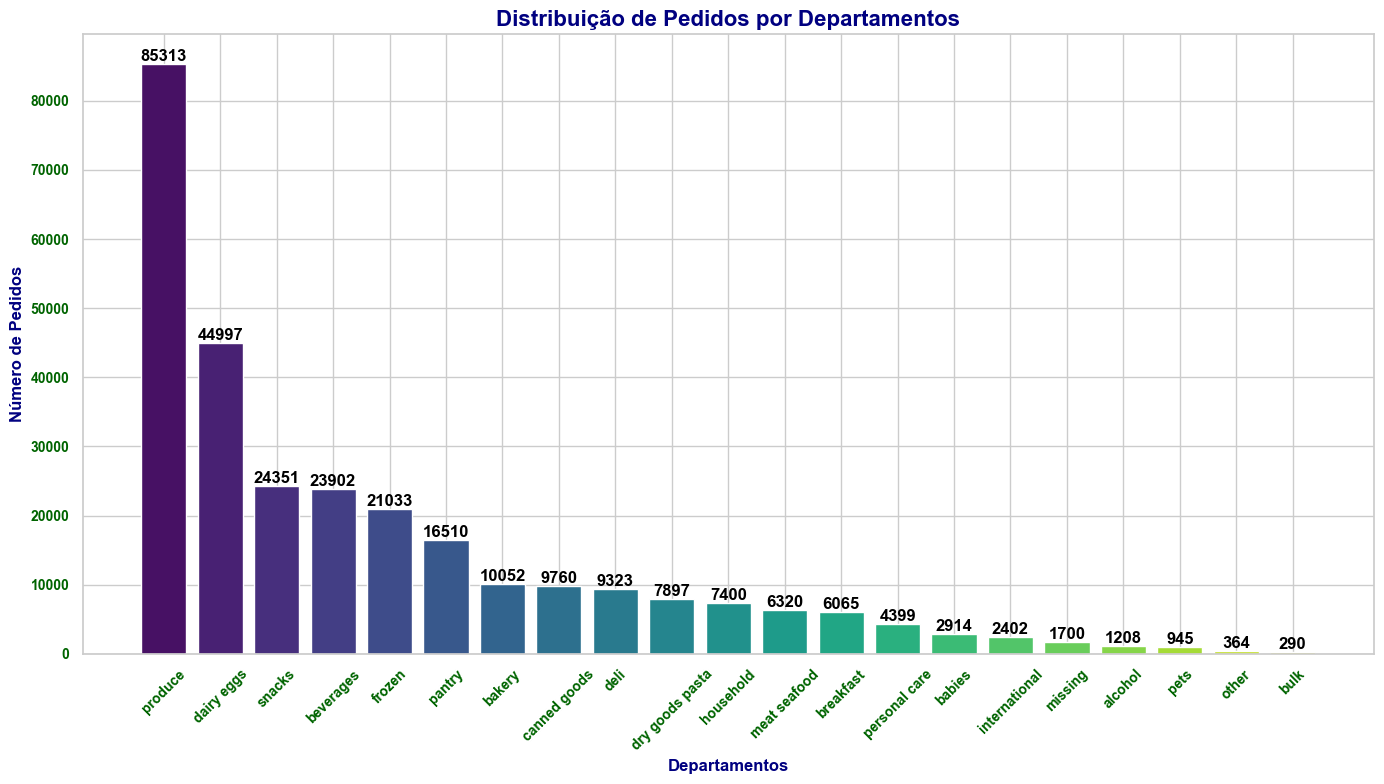

In [33]:
# Mostrar quais departamentos vendem mais

contador_departamentos = dfDetalhesProdutos.groupBy("department").count()
contador_departamentos_pandas = contador_departamentos.toPandas()
contador_departamentos_pandas.sort_values(by="count", ascending=False, inplace = True)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 8)) 
bars = plt.bar(contador_departamentos_pandas['department'], contador_departamentos_pandas['count'], color=sns.color_palette("viridis", len(contador_departamentos_pandas)))
plt.title('Distribuição de Pedidos por Departamentos', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Departamentos', fontsize=12, fontweight='bold', color='navy')
plt.ylabel('Número de Pedidos', fontsize=12, fontweight='bold', color='navy')
plt.xticks(rotation=45, fontsize=10, fontweight='bold', color='darkgreen')
plt.yticks(fontsize=10, fontweight='bold', color='darkgreen')
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontweight='bold', color='black')
plt.show()

Implementar promoções e programas de fidelidade para os departamentos mais pedidos como o de hortifrúti e o de ovos, visando aumentar o valor médio das vendas.

Implementar um Marketing Direcionado para aumentar o interesse dos consumidores pelos departamentos menos pedidos como o de PETS e o de nozes e grãos (BULK). Isso pode incluir amostras grátis, demonstrações em loja, e promoções cruzadas com produtos populares de outros departamentos. 

C:\Users\NFC\AppData\Local\Temp\ipykernel_17636\2380484494.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='order_hour_of_day', y='count', data=horario_pedidos, palette=palette, edgecolor='grey')


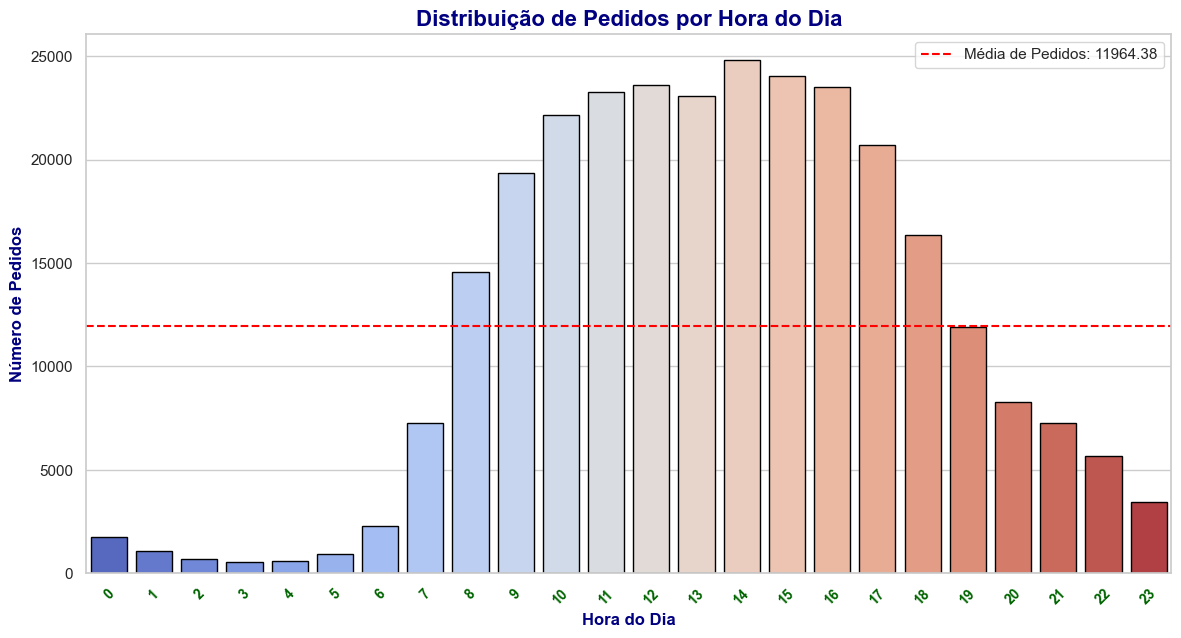

In [34]:
# Mostrar os horários de pico para compras

horario_pedidos = dfDetalhesProdutos.groupBy('order_hour_of_day').count().toPandas()
horario_pedidos.sort_values('order_hour_of_day', inplace=True)

sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", len(horario_pedidos))
plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(x='order_hour_of_day', y='count', data=horario_pedidos, palette=palette, edgecolor='grey')

for bar in bar_plot.patches:
    bar.set_linewidth(1)
    bar.set_edgecolor('black')

mean_count = horario_pedidos['count'].mean()
plt.axhline(mean_count, color='red', linewidth=1.5, linestyle='--', label=f'Média de Pedidos: {mean_count:.2f}')
plt.title('Distribuição de Pedidos por Hora do Dia', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Hora do Dia', fontsize=12, fontweight='bold', color='navy')
plt.ylabel('Número de Pedidos', fontsize=12, fontweight='bold', color='navy')
plt.xticks(rotation=45, fontsize=10, fontweight='bold', color='darkgreen')
plt.legend()
plt.show()

Conforme observado no histograma, os horários de pico ocorrem entre as 10h e as 17h. Para lidar com essa demanda elevada, é essencial aumentar a capacidade de atendimento. Recomenda-se reforçar o pessoal durante essas horas para garantir um atendimento ágil e eficiente. Isso inclui não apenas o aumento no número de caixas, mas também o reforço nas equipes responsáveis pela reposição de produtos e pelo atendimento ao cliente. Adicionalmente, é crucial aprimorar o gerenciamento de filas para minimizar o tempo de espera, maximizando assim a satisfação dos clientes.

In [35]:
# Mostrar a frequência com que os produtos são reordenados

frequencia_produtos_reordenados = dfDetalhesProdutos.groupBy("product_name").agg(sum("reordered").alias("total_reordernacoes"))
frequencia_produtos_pd = frequencia_produtos_reordenados.toPandas()

frequencia_produtos_pd['frequencia_relativa'] = (frequencia_produtos_pd['total_reordernacoes'] / frequencia_produtos_pd['total_reordernacoes'].sum()) * 100

frequencia_produtos_pd = frequencia_produtos_pd.sort_values(by='total_reordernacoes', ascending=False)
frequencia_produtos_pd['frequencia_relativa_acumulada'] = frequencia_produtos_pd['frequencia_relativa'].cumsum()

frequencia_produtos_pd.head(20)

,product_name,total_reordernacoes,frequencia_relativa,frequencia_relativa_acumulada
1949,Banana,3506,2.067046,2.067046
2383,Bag of Organic Bananas,2705,1.594798,3.661844
11333,Organic Baby Spinach,1725,1.017015,4.678859
13508,Organic Strawberries,1715,1.011119,5.689978
18043,Organic Avocado,1267,0.746990,6.436969
814,Organic Hass Avocado,1226,0.722818,7.159786
17095,Large Lemon,1225,0.722228,7.882014
15068,Strawberries,1012,0.596649,8.478663
4519,Limes,876,0.516467,8.995130
14277,Organic Raspberries,867,0.511161,9.506291


Realizar um estoque priorizado: produtos como Banana, saco de bananas orgânicas e espinafre ôrganicos para bebês, que têm altas taxas de reordenação, devem ser mantidos em estoque de forma adequada para evitar faltas. Isso pode envolver ajustar os níveis de estoque baseando-se nas taxas de reordenação para garantir disponibilidade contínua sem superestocagem.

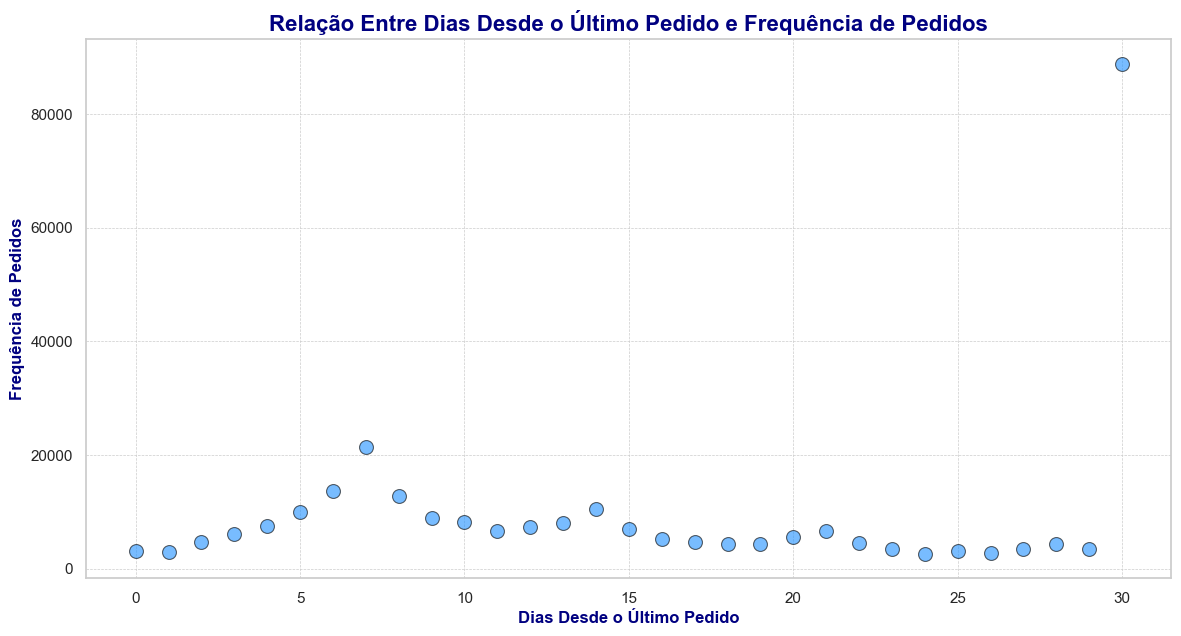

In [36]:
# Relação Entre Dias Desde o Último Pedido e Frequência de Pedidos

dfDetalhesProdutos_pd = dfDetalhesProdutos.select("days_since_prior_order", "order_id").toPandas()
frequencia_pedidos = dfDetalhesProdutos_pd.groupby("days_since_prior_order").size().reset_index(name="frequencia_pedidos")


sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(x="days_since_prior_order", y="frequencia_pedidos", data=frequencia_pedidos, 
                               s=100, color="dodgerblue", edgecolor="black", alpha=0.7)
plt.title("Relação Entre Dias Desde o Último Pedido e Frequência de Pedidos", fontsize=16, fontweight='bold', color='navy')
plt.xlabel("Dias Desde o Último Pedido", fontsize=12, fontweight='bold', color='navy')
plt.ylabel("Frequência de Pedidos", fontsize=12, fontweight='bold', color='navy')
plt.grid(True, linestyle='--', linewidth=0.5)

for artist in scatter_plot.collections:
    artist.set_alpha(0.6)

plt.show()

Esse gráfico mostra dados muito interessantes, o primeiro deles é o pico no dia 30, o que mostra que a maioria dos clientes tendem a fazer compras em um ciclo mensal, e que costumam fazer compras mais compras pouco tempo depois de terem visitado o supermercado (como podemos ver entre 5 a 10 dias).

Logo, podemos fazer previsões de demandas e políticas de reordenamento, considerando que a maioria das pessoas compram em um ciclo mensal, é fundamental garantir que o reabastecimento de estoque seja alinhado com os padrões de demanda identificados.

C:\Users\NFC\AppData\Local\Temp\ipykernel_17636\1359456118.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(
C:\Users\NFC\AppData\Local\Temp\ipykernel_17636\1359456118.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(frequencia_dias_pd['dia_da_semana'], rotation=0)


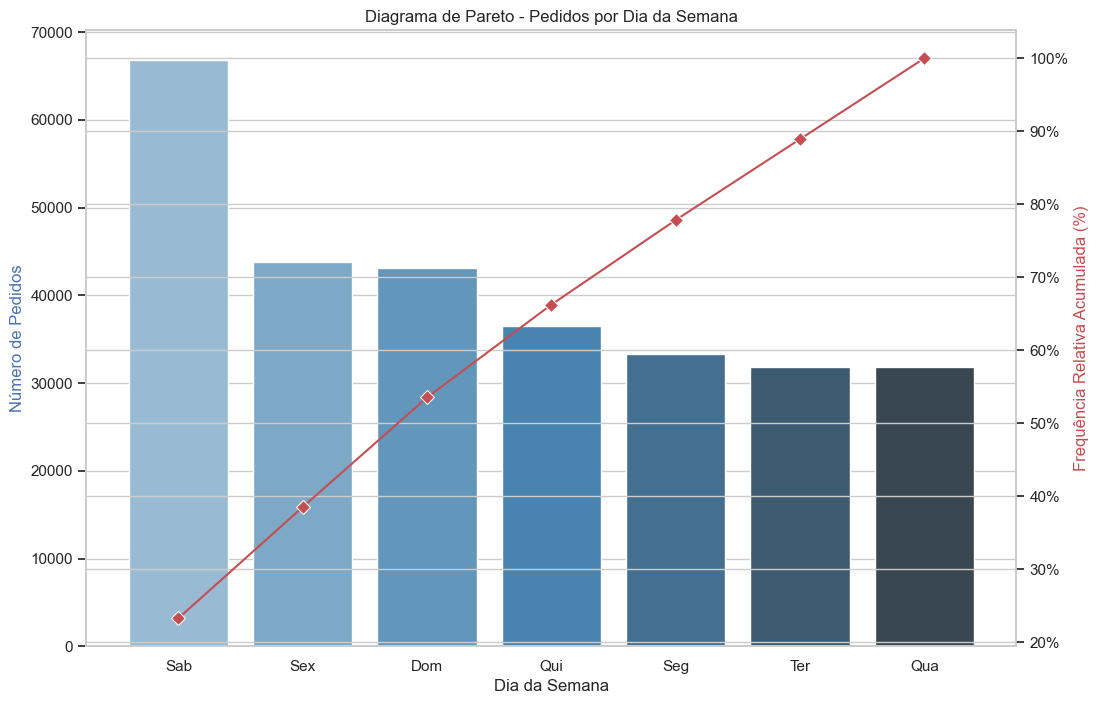

In [37]:
frequencia_dias = dfDetalhesProdutos.groupBy("dia_da_semana").agg(count("order_id").alias("total_pedidos"))
frequencia_dias = frequencia_dias.orderBy(col("total_pedidos").desc())

frequencia_dias_pd = frequencia_dias.toPandas()
frequencia_dias_pd['frequencia_relativa'] = (frequencia_dias_pd['total_pedidos'] / frequencia_dias_pd['total_pedidos'].sum()) * 100
frequencia_dias_pd['frequencia_relativa_acumulada'] = frequencia_dias_pd['frequencia_relativa'].cumsum()

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 8))
bar_plot = sns.barplot(
    x='dia_da_semana', 
    y='total_pedidos', 
    data=frequencia_dias_pd, 
    ax=ax1, 
    palette='Blues_d'
)
ax1.set_ylabel('Número de Pedidos', color='b')
ax1.set_xlabel('Dia da Semana')
ax1.set_title('Diagrama de Pareto - Pedidos por Dia da Semana')
ax1.set_xticklabels(frequencia_dias_pd['dia_da_semana'], rotation=0)

ax2 = ax1.twinx()

line_plot = sns.lineplot(
    x=frequencia_dias_pd['dia_da_semana'], 
    y=frequencia_dias_pd['frequencia_relativa_acumulada'], 
    ax=ax2, 
    color='r', 
    marker='D', 
    markersize=7,
    sort=False
)
ax2.set_ylabel('Frequência Relativa Acumulada (%)', color='r')

from matplotlib.ticker import PercentFormatter
ax2.yaxis.set_major_formatter(PercentFormatter())
plt.show()

No diagrama a cima podemos observar claramente que há dias com atividade significativamente maior de compras. Especificamente, os dias como Sábado, Sexta e Domingo mostram os maiores volumes de pedidos. Portanto, uma abordagem seria aumentar o staff (número de funcionários) nos dias de pico como sexta, sábado e domingo para lidar com o aumento do fluxo de clientes. Isso pode incluir não só caixas, mas também pessoal para reposição de produtos, limpeza e segurança. Além disso, podemos considerar estender os horários de funcionamento nessas datas para acomodar melhor os picos de atividade sem sobrecarregar a infraestrutura durante as horas normais.